In [1]:
# import random
# import sqlite3
# import threading
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm # progress bar
import tensorflow as tf
import matplotlib.pyplot as plt
from pymongo import MongoClient
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [2]:
# conn = sqlite3.connect("../Dataset/dataset.db")

In [3]:
# df_train = pd.read_sql_query(
#         sql="SELECT * FROM Photo WHERE Repartition LIKE 'train';",
#         con=conn,
#         index_col='id',
#     )
# df_train.shape # (487_227, 4)
# Temps : 1m 2.5s

In [4]:
# df_test = pd.read_sql_query(
#         sql="SELECT * FROM Photo WHERE Repartition LIKE 'test';",
#         con=conn,
#         index_col='id',
#     )
# df_test.shape # (155_489, 4)
# Temps : 1m 13.6s

In [5]:
# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27017/Scibio")  # Remplacez par l'URL de votre serveur MongoDB
db = client["Scribio"]  # Nom de la base de données
collection = db["Dataset"]  # Nom de la collection
# Temps : 0.0s

In [6]:
def fetch_data(repartition: str, nbr: int):
    # Tout --------------------------------------------
    query = {"Repartition": repartition}
    documents = collection.find(query)
    print(f"fetch {repartition} OK !!!")
    
    # Trop long
    #count = collection.count_documents(query) # Nombre de documents dans la collection
    #print(f"Nombre de documents : {count}")

    images = []
    labels = []
    
    # Parcours et transformation des photos avec barre de progression 
    with tqdm(total=nbr, desc="Proccessing" , position=0, leave=True) as pbar:
        for doc in documents:
            images.append(np.array(doc["Tableau_Pixels"], dtype=np.float32))
            labels.append(doc["Label"])
            pbar.update(1) # Mettre à jour la barre de progression
            
    return np.array(images), np.array(labels, dtype=str)

In [7]:
# Recupération des données d'entrainement
X_train, y_train = fetch_data("train", 487_227)
# Temps : 5m 45.0s ??????????????? Si vite ?????

# Temps : 150min 45.6s (pour tout A)
# Temps : trop long !!!!!!!! :( (pour tout)
# Temps : 1min + pas fini (pour 5 aléatoire simple)
# Temps : 3min + pas fin (pour 5 aléatoire Id)

fetch train OK !!!


Proccessing: 100%|██████████| 487227/487227 [05:41<00:00, 1426.88it/s]


In [8]:
# Recupération des données de test
X_test, y_test = fetch_data("test", 155_489)
# Temps : 47min 25.8s

# Temps : 157min 57.6s (pour A)
# Temps :

fetch test OK !!!


Proccessing: 100%|██████████| 155489/155489 [47:15<00:00, 54.85it/s]  


In [9]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder = LabelEncoder()
label_encoder

y_train2 = label_encoder.fit_transform(y_train)  # Convertit les étiquettes (lettres/nombres) en indices numériques
y_test2 = label_encoder.transform(y_test)

In [10]:
# Afficher quelques informations
print(f"Taille de X_train: {X_train.shape}, y_train: {y_train.shape}, y_train2: {y_train2.shape}")
print(f"Taille de X_test: {X_test.shape}, y_test: {y_test.shape}, y_test2: {y_test2.shape}")

Taille de X_train: (487227, 2500), y_train: (487227,), y_train2: (487227,)
Taille de X_test: (155489, 2500), y_test: (155489,), y_test2: (155489,)


In [11]:
# Transformation des colonnes des df en tableau numpy
# X_train = df_train['Tableau_Pixels']
# y_train = df_train['Label']
# X_test = df_test['Tableau_Pixels']
# y_test = df_test['Label']
# Temps : 

In [12]:
# Reseau de neurones
model = Sequential([
    # Dense(), # input layer : 2500 neurones (50x50 pixels)
    Dense(1024, activation='relu', input_shape=(2500,)), # hidden layer : 1024 neurones avec fonction d'activation relu
    Dropout(0.3), # Dropout layer pour éviter le surapprentissage (overfitting)
    Dense(512, activation='relu'), # hidden layer : 512 neurones avec fonction d'activation relu
    Dropout(0.3),
    Dense(256, activation='relu'), # hidden layer : 256 neurones avec fonction d'activation relu
    Dropout(0.3),
    Dense(62, activation='sigmoid') # output layer : 62 classes (0-9, A-Z, a-z) avec softmax pour la classification
])

model.compile(
    optimizer=Adam(learning_rate=0.0001), # optimizer : Adam avec learning rate de 0.0001
    loss='sparse_categorical_crossentropy', # loss : sparse_categorical_crossentropy pour la classification
    metrics=['accuracy'] # metrics : accuracy pour évaluer la performance du modèle
  )

c:\Users\yfour\Documents\EnvsPython\Scribio\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary() # Afficher le résumé du modèle

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │     2,561,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,233,086 (12.33 MB)

 Trainable params: 3,233,086 (12.33 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(X_train, y_train2, epochs=10)

Epoch 1/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 1271s 83ms/step - accuracy: 0.6049 - loss: 1.4826
Epoch 2/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 169s 11ms/step - accuracy: 0.7617 - loss: 0.7722
Epoch 3/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 173s 11ms/step - accuracy: 0.7806 - loss: 0.6984
Epoch 4/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 168s 11ms/step - accuracy: 0.7903 - loss: 0.6580
Epoch 5/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 164s 11ms/step - accuracy: 0.7939 - loss: 0.6380
Epoch 6/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 164s 11ms/step - accuracy: 0.7978 - loss: 0.6234
Epoch 7/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 165s 11ms/step - accuracy: 0.8026 - loss: 0.6080
Epoch 8/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 159s 10ms/step - accuracy: 0.8055 - loss: 0.5976
Epoch 9/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 158s 10ms/step - accuracy: 0.8065 - loss: 0.5895
Epoch 10/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 158s 10ms/step - accuracy: 0.8087 - loss: 0.5828


In [15]:
# Sauvegarder le modèle
model.save("Scribio.h5")  # Format HDF5 (.h5)

In [16]:
y_predicted = model.predict(X_test)
y_predicted[1]

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


array([1.04191720e-01, 9.31259431e-03, 4.93538100e-03, 7.78605521e-04,
       1.65922925e-01, 6.80292863e-03, 7.94956810e-04, 2.58825906e-02,
       1.28687895e-03, 6.58785775e-02, 8.40343833e-01, 3.27978586e-03,
       2.15799622e-02, 1.18644526e-02, 4.01224504e-04, 2.38704849e-02,
       3.30650038e-03, 1.19605549e-01, 5.98245114e-03, 4.42360155e-03,
       4.52870270e-03, 4.47426923e-04, 2.85095215e-01, 3.51084322e-02,
       1.27630793e-02, 2.51179691e-02, 1.38198855e-04, 9.77192819e-03,
       1.13929133e-03, 1.20631844e-01, 1.80554460e-03, 5.26003307e-04,
       5.14470623e-04, 2.44698115e-02, 1.79111511e-01, 1.87113565e-05,
       6.57742098e-02, 3.56222939e-04, 8.38767795e-04, 7.13273510e-03,
       8.30319338e-03, 4.95578442e-03, 8.23531859e-03, 1.01009481e-01,
       7.33790745e-04, 5.41012967e-03, 3.66029143e-03, 1.37157058e-02,
       1.21339774e-02, 3.56334746e-01, 1.68118801e-03, 1.19029928e-03,
       8.22382700e-03, 1.06423914e-01, 1.42765569e-03, 5.29085755e-01,
      

In [17]:
np.argmax(y_predicted[1])

10

In [18]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
y_predicted_labels[:5]

[10, 10, 10, 10, 4]

Text(95.72222222222221, 0.5, 'Truth')

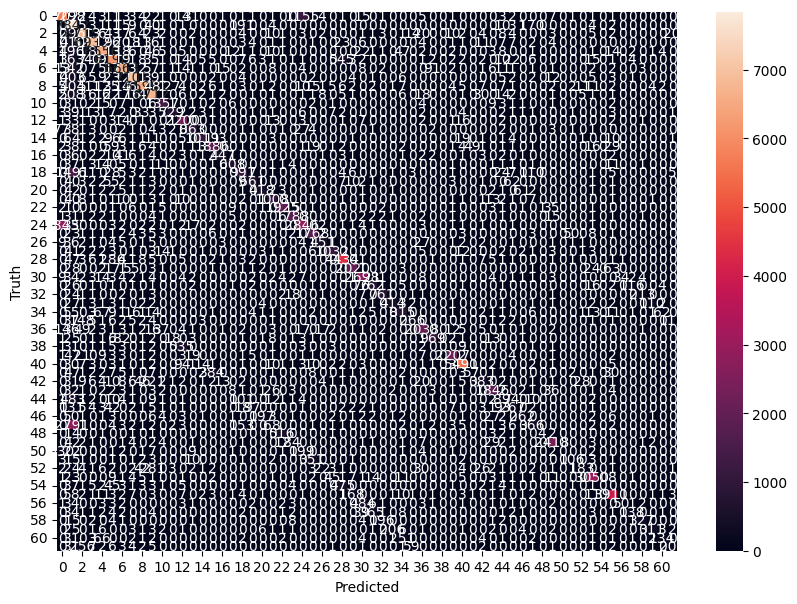

In [19]:
# Matrice de confusion
cm = tf.math.confusion_matrix(labels=y_test2, predictions=y_predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')